In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

C:\Users\Dylan Kangas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Take data file and convert class names to class numbers 

In [2]:
df = pd.read_csv('data/Amazon-Products.csv')

class_labels = df['main_category']

unique_classes = class_labels.unique()

# Map class labels to numbers
class_to_number = {class_label: idx for idx, class_label in enumerate(unique_classes)}

# Replace class labels with numbers
df['class_numbers'] = df['main_category'].map(class_to_number)

# Save the modified dataframe to a new CSV file
df.to_csv('data.csv', index=False)

print(class_to_number)


{'appliances': 0, 'car & motorbike': 1, 'tv, audio & cameras': 2, 'sports & fitness': 3, 'grocery & gourmet foods': 4, 'home & kitchen': 5, 'pet supplies': 6, 'stores': 7, 'toys & baby products': 8, "kids' fashion": 9, 'bags & luggage': 10, 'accessories': 11, "women's shoes": 12, 'beauty & health': 13, "men's shoes": 14, "women's clothing": 15, 'industrial supplies': 16, "men's clothing": 17, 'music': 18, 'home, kitchen, pets': 19}


Read converted data file and store text and classes in arrays

In [3]:
def read_column_from_csv(csv_file, column_number):
    with open(csv_file, mode='r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if len(row) > column_number:
                yield row[column_number]

csv_file = "data.csv"

train_labels = []
train_texts = []
count = 0

for value in read_column_from_csv(csv_file, 10):
    train_labels.append(int(value))
    count += 1

for value in read_column_from_csv(csv_file, 1):
    train_texts.append(value)

number = len(train_labels)

print(f"Products: {number}")
print(len(train_texts))
print(len(train_labels))

Products: 551585
551585
551585


Test/Train Split

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

# You can check the sizes of the sets
print("Training set size:", len(train_texts))
print("Testing set size:", len(validation_texts))

Training set size: 441268
Testing set size: 110317


Train the model and save it

In [5]:
num_epochs = 1
max_length = 128
initial_batch_size = 81

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model and move it to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=20).to(device)

# Define your dataset class
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Determine a suitable batch size
current_batch_size = initial_batch_size
while True:
    try:
        train_dataset = MyDataset(train_texts, train_labels, tokenizer, max_length)
        train_dataloader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)
        break
    except Exception as e:
        print(f"Batch size {current_batch_size} failed with error: {e}")
        current_batch_size //= 2
        print(f"Trying batch size {current_batch_size}")

print(f"Using batch size: {current_batch_size}")

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using batch size: 81


C:\Users\Dylan Kangas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Epoch 1/1, Avg. Loss: 0.4787


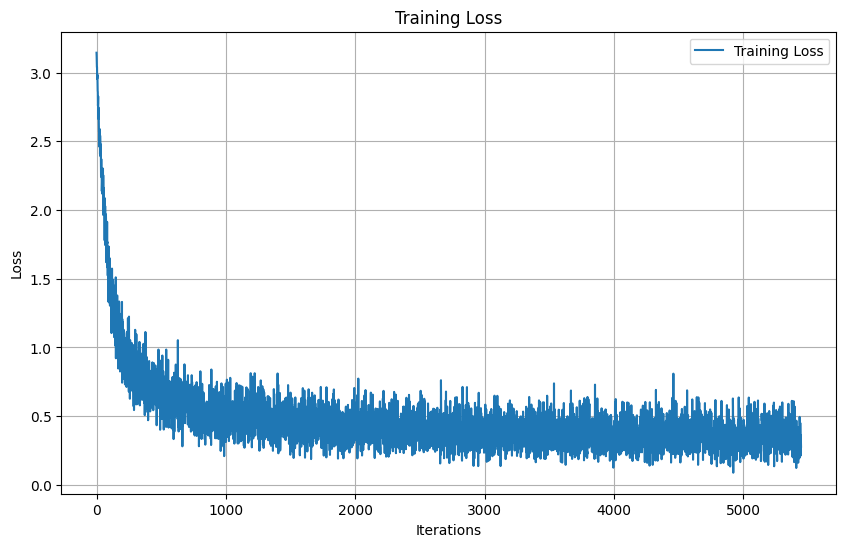

In [6]:
# Training loop with progress bars and loss collection
model.train()
losses = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())  # Append the current loss to the list

        progress_bar.set_postfix({'loss': epoch_loss / len(train_dataloader)})

        
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg. Loss: {avg_epoch_loss:.4f}")
    # # Save the model on each epoch
    # model.save_pretrained("model/epoch" + str(epoch+1) + "/")

    
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model.save_pretrained("model/")

Test Accuracy

In [7]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained("model/")
model.to(device)  # Move model to the correct device

# Evaluation
model.eval()
total_correct = 0
total_samples = 0

# validation_texts = [
#     "Star Wars Epic Hero Series Darth Vader 4 Action Figure",
#     "Nerf Elite 2.0 Commander RD-6 Blaster, 12 Official Nerf Darts, 6-Dart Rotating Drum, Built-In Customizing Capabilities",
#     "Auto Drive Car Wash Microfiber Sponge, Chenille Pile & Scrubber Back, Blue, 1 piece",
#     "VIKING Wheel Brush for Rims, Cleaning Brush for Tires, Tire Brush for Car, Grey, 10.3 inch x 3.3 inch x 3.8 Inch"
# ]
# validation_labels = [1, 1, 0, 0]  # Example labels for validation, replace with your actual labels

validation_dataset = MyDataset(validation_texts, validation_labels, tokenizer, max_length)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

incorrect_predictions = []

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        # Track incorrect predictions
        for i in range(len(predictions)):
            if predictions[i] != labels[i]:
                incorrect_predictions.append((validation_texts[total_samples + i], predictions[i].item(), labels[i].item()))

        total_correct += torch.sum(predictions == labels).item()
        total_samples += len(labels)

print("Incorrect Predictions:")
for text, predicted, actual in incorrect_predictions:
    print(f"Text: {text}")
    print(f"Predicted Label: {predicted}, Actual Label: {actual}\n")

accuracy = total_correct / total_samples
print("Validation Accuracy:", accuracy)


Incorrect Predictions:
Text: Adidas Men's Ellipto Run M Leather Shoe
Predicted Label: 7, Actual Label: 14

Text: Lancer Active Running Shoe (Active-32)
Predicted Label: 14, Actual Label: 7

Text: Dixcy Scott Cotton Men’s Trunk Modern Fit Solid Innerwear Pack of 3
Predicted Label: 17, Actual Label: 7

Text: Noty Girl's Satin Solid Night Suit Set Pack of 1
Predicted Label: 9, Actual Label: 15

Text: ALCiS Women's Solid Slim Fit Tights
Predicted Label: 15, Actual Label: 7

Text: Clara Made with Swarovski Zirconia BIS Hallmarked 92.5 Sterling Silver Platinum Plated Mia Solitaire Earring Gift For Wome...
Predicted Label: 11, Actual Label: 7

Text: Van Heusen Men's Track Pants
Predicted Label: 3, Actual Label: 7

Text: Amazon Brand - Inkast Denim Co. Men's Slim Fit
Predicted Label: 17, Actual Label: 7

Text: Adidas Men Kray 3.0 Ms Running Shoes
Predicted Label: 7, Actual Label: 14

Text: Vector X Velocity Football Shoes (Black-Silver)
Predicted Label: 14, Actual Label: 7

Text: Qingyuan Hand